# Proyecto - Parte I

**Alumno**: Javier López Malone 

**Profesora**: Estefania Karina Susanj 

**Tutor**: Rubén Baquel

**Dataset seleccionado**: Spotify tracks


## Preguntas

¿ Se puede decir que a mayor volúmen la canción está asociada con la energía ?
¿ El volúmen tiene alguna relación con la popularidad?

### Imports

In [3]:
from decimal import Decimal
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('..\\..\\datasets\\2. spotify_tracks\\dataset.csv')
pd.reset_option('display.max_rows')

In [4]:
# HELPER FUNCTIONS

def get_outliers_IQR(dataFrame: pd.DataFrame, columns:str|list=None):
    """ Calculates dataframe column outliers based on interquartile range (IQR)
    """
    if columns is None:
        columns = dataFrame[dataFrame.columns[(dataFrame.dtypes == 'float64') | (dataFrame.dtypes == 'int64')]].columns.to_list()
    
    if columns:
        Q1 = dataFrame[columns].quantile(0.25)
        Q3 = dataFrame[columns].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        return (dataFrame[columns] < lower_bound) | (dataFrame[columns] > upper_bound)
    else:
        return None

### Limpieza de datos

In [5]:
# Limpieza de datos
column_to_drop = 'Unnamed: 0'

if column_to_drop in df.columns:
    df.drop(column_to_drop, axis='columns', inplace=True)
df = df.dropna(subset=['artists'])
df = df.drop_duplicates(subset=['track_id', 'artists', 'album_name', 'track_name'], keep='first')
df.drop(df[df['popularity']<10].index, axis=0, inplace=True)

# Top de géneros musicales para limitar el análisis
top_n = 10
top_genres=df.groupby('track_genre')['popularity'].median().sort_values(ascending=False).head(top_n)
df_top_genres = df[df['track_genre'].isin(top_genres.index)]
numerical_cols = df_top_genres[df_top_genres.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]

# Columnas numéricas
numerical_cols = df[df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]]

# Limpieza de outliers
genre_summaries = {}

for genre in top_genres.index:
    df_filtered = df[df['track_genre']==genre]
    df_filtered_count = df[df['track_genre']==genre]['track_id'].count()
    outliers=get_outliers_IQR(df_filtered)
    print(f"Outliers for {genre.upper()} [{df_filtered_count} tracks]:")
    print(f"{outliers.sum()}\n")
    
dfs_without_outliers = []

for genre in top_genres.index:
    df_filtered = df[df['track_genre'] == genre]
    outliers = get_outliers_IQR(df_filtered)
    df_without_outliers = df_filtered[~outliers.any(axis=1)]
    if not df_without_outliers.empty:
        dfs_without_outliers.append(df_without_outliers)

if dfs_without_outliers:
    df = pd.concat(dfs_without_outliers)

Outliers for ROCK [79 tracks]:
popularity           7
duration_ms          5
danceability         1
energy               1
key                  0
loudness             4
mode                 0
speechiness         12
acousticness         7
instrumentalness    16
liveness             4
valence              0
tempo                0
time_signature       5
dtype: int64

Outliers for DANCE [292 tracks]:
popularity          18
duration_ms          9
danceability         2
energy               0
key                  0
loudness             6
mode                 0
speechiness         29
acousticness        19
instrumentalness    53
liveness            26
valence              0
tempo               15
time_signature       7
dtype: int64

Outliers for LATIN [100 tracks]:
popularity           0
duration_ms          3
danceability         2
energy               1
key                  0
loudness             4
mode                 0
speechiness         16
acousticness         3
instrumentalness    15
l

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1164 entries, 91012 to 71998
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          1164 non-null   object 
 1   artists           1164 non-null   object 
 2   album_name        1164 non-null   object 
 3   track_name        1164 non-null   object 
 4   popularity        1164 non-null   int64  
 5   duration_ms       1164 non-null   int64  
 6   explicit          1164 non-null   bool   
 7   danceability      1164 non-null   float64
 8   energy            1164 non-null   float64
 9   key               1164 non-null   int64  
 10  loudness          1164 non-null   float64
 11  mode              1164 non-null   int64  
 12  speechiness       1164 non-null   float64
 13  acousticness      1164 non-null   float64
 14  instrumentalness  1164 non-null   float64
 15  liveness          1164 non-null   float64
 16  valence           1164 non-null   float64


In [7]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.000000,1164.0
mean,68.270619,202354.642612,0.639902,0.682142,5.380584,-5.721472,0.561856,0.058675,0.196094,0.000194,0.157939,0.479445,118.090061,4.0
std,9.739150,39026.880728,0.127167,0.168209,3.578670,2.028685,0.496372,0.029437,0.224855,0.000890,0.094903,0.211738,24.820012,0.0
min,37.000000,83040.000000,0.259000,0.095800,0.000000,-15.605000,0.000000,0.024100,0.000004,0.000000,0.021100,0.039700,55.832000,4.0
25%,63.000000,175622.750000,0.558000,0.571000,2.000000,-6.868750,0.000000,0.037375,0.024125,0.000000,0.093100,0.319750,99.116750,4.0
50%,69.000000,199968.000000,0.654500,0.696000,6.000000,-5.443500,1.000000,0.048700,0.100500,0.000000,0.121000,0.466000,119.815500,4.0
75%,75.000000,224596.250000,0.733000,0.811250,8.000000,-4.270750,1.000000,0.070600,0.296000,0.000013,0.196000,0.630250,132.023250,4.0
max,97.000000,404386.000000,0.953000,0.996000,11.000000,-0.706000,1.000000,0.167000,0.934000,0.010600,0.606000,0.969000,200.072000,4.0


## Gráficos

[Text(0.5, 0, 'popularity'),
 Text(1.5, 0, 'duration_ms'),
 Text(2.5, 0, 'explicit'),
 Text(3.5, 0, 'danceability'),
 Text(4.5, 0, 'energy'),
 Text(5.5, 0, 'loudness'),
 Text(6.5, 0, 'speechiness'),
 Text(7.5, 0, 'acousticness'),
 Text(8.5, 0, 'instrumentalness'),
 Text(9.5, 0, 'liveness'),
 Text(10.5, 0, 'valence'),
 Text(11.5, 0, 'tempo')]

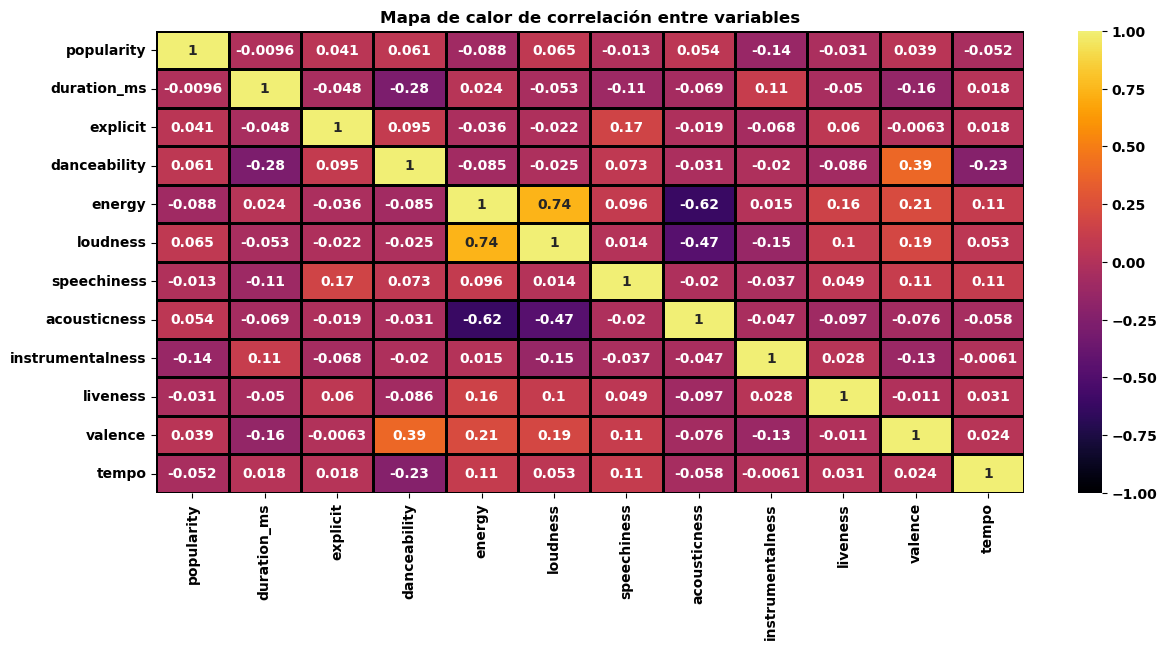

In [35]:
corr_pop = df_top_genres.drop(['key', 'mode', 'time_signature'], axis=1).corr(method='pearson', numeric_only=True)
#This code calculates the Pearson correlation coefficient between popularity and other musical features,
# excluding irrelevant columns.

plt.figure(figsize=(14,6))
heatmap = sns.heatmap(corr_pop,annot=True, vmin=-1.0, vmax=1.0, center=0.05, cmap='inferno', linewidths=1, linecolor='Black')
heatmap.set_title("Mapa de calor de correlación entre variables")
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=90)

Observaciones:

Se puede apreciar que las únicas características con una mínima correlación son loudness y energy.

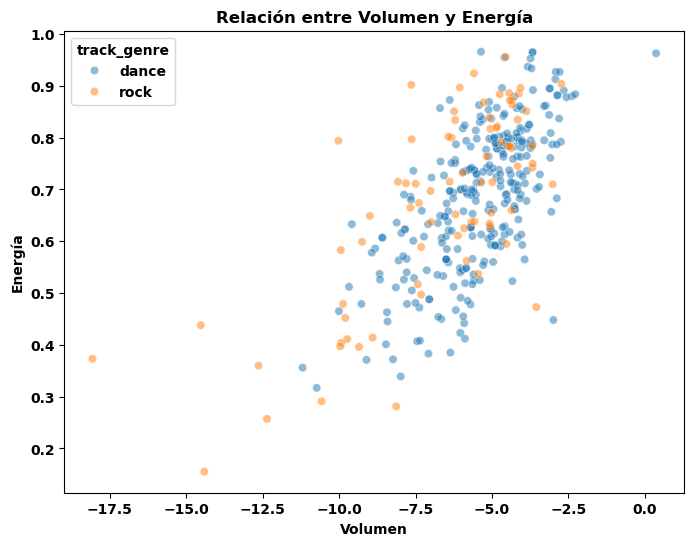

In [44]:
df_genres  = df_top_genres[(df_top_genres['track_genre']==top_genres.index[0]) | (df_top_genres['track_genre']==top_genres.index[1])] 
loudness = df_genres['loudness']
energy = df_genres['energy']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_genres, x=df_top_genres['loudness'], y=df_top_genres['energy'],hue='track_genre', alpha=.5)
plt.title(f"Relación entre Volumen y Energía")
plt.xlabel("Volumen")
plt.ylabel("Energía")
plt.show()

Observaciones: Si viene se nota una concentración similar de puntos, los puntos están un poco dispersos.

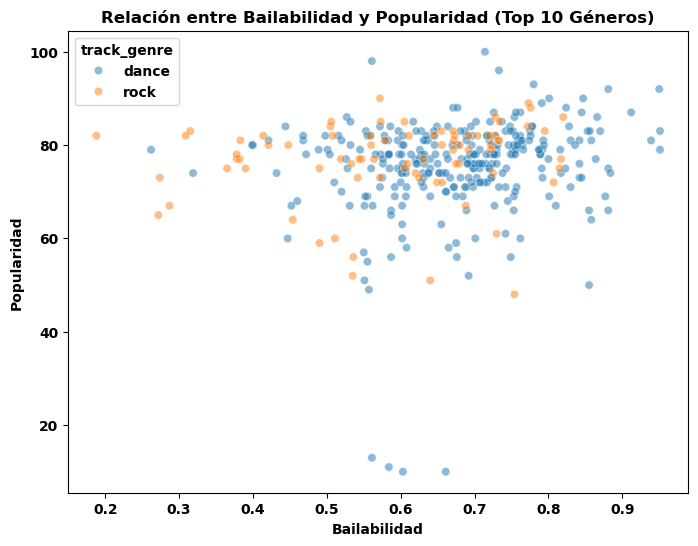

In [50]:
df_genres  = df_top_genres[(df_top_genres['track_genre']==top_genres.index[0]) | (df_top_genres['track_genre']==top_genres.index[1])] 
danceability = df_top_genres['danceability']
popularity = df_top_genres['popularity']

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_genres, x=danceability, y=popularity, hue='track_genre', alpha=.5)
plt.title(f"Relación entre Bailabilidad y Popularidad (Top {top_n} Géneros)")
plt.xlabel("Bailabilidad")
plt.ylabel("Popularidad")
plt.show()

Observaciones no se aprecia una relación clara entre bailabilidad y popularidad.